In [2]:
from google.colab import drive
drive.mount('/content/drive')
import os
cwd = os.getcwd()
path = os.getcwd() + '/drive/MyDrive/DL_Course/HM_3_Part_2/'
# os.chdir(path)
# !unzip '/content/drive/MyDrive/DL_Course/HM_3_Part_2/glove.6B.zip'
# os.chdir(cwd)
# del cwd

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import numpy as np
from scipy import spatial
import time
import torch 
import torch.nn as nn
import pandas as pd
from torch.utils.data import Dataset, DataLoader, random_split
import torch.optim as optim
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from torch.autograd import Variable

import pandas as pd
import matplotlib.pyplot as plt
import joblib   
from numpy import interp
from itertools import cycle
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.metrics import ConfusionMatrixDisplay


In [4]:
embed_dim = 300
enc = 'iso-8859-1'
file = path+'Trec_Train_dataset.txt'

glove = pd.read_csv(path + 'glove.6B.{}d.txt'.format(embed_dim), sep=" ", quoting=3, header=None, index_col=0)
embed_dict = {key: val.values for key, val in glove.T.items()}


In [4]:
def load_dataset(file,enc,embed_dim):
    # sentence_keys = []
    # sentence_words = []
    X = []
    text_labels = []
    keys = list(embed_dict.keys())
    sentence_max_len = -np.inf
    with open(file,'r',encoding=enc) as f:
                for line in f:
                    x_dat = {}
                    # l = line.replace('\n','').replace('-',' ').split(' ')
                    l = line.lower().replace('\n','').replace('-',' ').split(' ')
                    text_labels.append(l[0][:l[0].index(':')])
                    x_dat['words'] = l[1:]
                    s = []
                    for word in l[1:]:
                        try:
                            s.append(np.array(keys.index(word)))
                        except ValueError:
                            embed_dict[word] = np.random.uniform(low = -0.25, high =0.25, size = (embed_dim,))
                            keys = list(embed_dict.keys())
                            s.append(np.array(keys.index(word)))
                    sentence_max_len = max(sentence_max_len,len(s))
                    x_dat['keys'] = np.array(s)
                    X.append(x_dat)
    unique_labels = list(set(text_labels))
    embed_dict['NULL'] = np.zeros(shape = (embed_dim,))
    return X, text_labels, unique_labels, sentence_max_len, list(embed_dict.keys()).index('NULL')

X,Y,Y_unique,sen_max_len, NULL_index =  load_dataset(file,enc,embed_dim)

In [38]:
def true_pos(confusion_mat,ind):
    return confusion_mat[ind][ind]

def true_neg(confusion_mat,ind):
    sum = 0
    for i in range(0,len(confusion_mat)):
        if i != ind:
            for j in range(0,len(confusion_mat[i])):
                if j != ind:
                    sum = sum + confusion_mat[i][j]
    return sum

def false_pos(confusion_mat,ind):
    sum = 0
    for i in range(0,len(confusion_mat[ind])):
        if i != ind:
            sum = sum + confusion_mat[ind][i]
    return sum

def false_neg(confusion_mat,ind):
    sum = 0
    for i in range(0,len(confusion_mat)):
        if i != ind:
            sum = sum + confusion_mat[i][ind]
    return sum


def generate_report(y_pred, y_true):
    uniqs = np.unique(np.concatenate((y_true,y_pred)))
    uniqs = np.sort(uniqs)

    tp = np.zeros(len(uniqs))
    tn = np.zeros(len(uniqs))
    fp = np.zeros(len(uniqs))
    fn = np.zeros(len(uniqs))

    confusion_mat = np.zeros((len(uniqs),len(uniqs)))
    for i in range(0,len(uniqs)):
        for j in range(0,len(y_true)):
            if y_true[j] == uniqs[i]:
                ind = np.where(uniqs == y_pred[j])[0][0]
                confusion_mat[i][ind] = confusion_mat[i][ind] + 1
    confusion_mat = confusion_mat
    print("\nThe confusion matrix")
    print(confusion_mat.astype(int))
    confusion_mat = confusion_mat.astype(float)


    for i in range(0,len(uniqs)):
        tp[i] = true_pos(confusion_mat,i)
        tn[i] = true_neg(confusion_mat,i)
        fp[i] = false_pos(confusion_mat,i)
        fn[i] = false_neg(confusion_mat,i)

    accuracy = np.zeros(len(uniqs))
    precision = np.zeros(len(uniqs))
    recall = np.zeros(len(uniqs))
    f1_score = np.zeros(len(uniqs))

    for i in range(0,len(uniqs)):
        accuracy[i] = (tp[i] + tn[i])/(tp[i] + fp[i] + tn[i] + fn[i])
        precision[i] = tp[i]/(tp[i] + fp[i])
        recall[i] = tp[i]/(tp[i] + fn[i])
        f1_score[i] = 2*(recall[i]*precision[i])/(recall[i]+precision[i])       

    micro_accuracy = (np.sum(tp)+np.sum(tn))/(np.sum(tp)+np.sum(fp)+np.sum(fn)+np.sum(tn))
    micro_precision = (np.sum(tp))/(np.sum(tp) + np.sum(fp))
    micro_recall = (np.sum(tp))/(np.sum(tp) + np.sum(fn))
    micro_f1_score = 2*(micro_recall*micro_precision)/(micro_recall+micro_precision)

    macro_accuracy = np.mean(accuracy)
    macro_precision = np.mean(precision)
    macro_recall = np.mean(recall)
    macro_f1_score = 2*(macro_recall*macro_precision)/(macro_recall + macro_precision)

    report = {}
    report["precision"] = np.round(precision,decimals=2)
    report["recall"] = np.round(recall,decimals=2)
    report["F1 score"] = np.round(recall,decimals=2)
    print()
    print(pd.DataFrame(report))
    print()
    print("Micro => "+str(round(micro_precision,5))+" "+str(round(micro_recall,5))+" "+str(round(micro_f1_score,5)))
    print("Macro => "+str(round(macro_precision,5))+" "+str(round(macro_recall,5))+" "+str(round(macro_f1_score,5)))


def generate_roc_curve(y_proba, y_true, title,classes,dir= None):
    n_classes = y_proba.shape[1]
    
    y_true = label_binarize(y_true, classes = range(n_classes))
    
    lw = 2
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    
    fpr["micro"], tpr["micro"], _ = roc_curve(y_true.ravel(), y_proba.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_proba[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
        
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])

    
    mean_tpr /= n_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    
    plt.figure(figsize = (10,10))
    plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)
    
    plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)
    
    colors = cycle(['red','blue','pink','green','yellow','violet','cyan','black','brown', 'gray'])
    
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color = color, lw=lw,
                 label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(classes[i], roc_auc[i]))
    plt.plot([0, 1], [0, 1], 'k--', lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="lower right")   
    if dir != None:
        plt.savefig(dir, dpi=300, bbox_inches='tight')
    plt.show()

def save_plots(ys,labels,dir = None,ylabel= None):
    for i in range(len(ys)):
        plt.plot(range(len(ys[i])),ys[i],label = labels[i])
    plt.legend()
    plt.xlabel('Epochs')
    plt.ylabel(ylabel)
    if dir != None:
        plt.savefig(dir  ,dpi = 300 , bbox_inches = 'tight')
    plt.show()

In [5]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y,test_size = 0.2, random_state = 42)

In [20]:
class CustomDataset(Dataset):
    def __init__(self,X,Y,Y_unique,sen_max_len, NULL_index):            
        self.X = X 
        self.Y = Y

        self.Y_unique = Y_unique
        self.s_max_len = sen_max_len
        self.NULL_index = NULL_index
        
    def __len__(self):
        return len(self.X)

    def __getitem__(self,idx):    
        label = self.Y_unique.index(self.Y[idx])
        dat1 =  self.X[idx]['keys']

        dat = np.zeros((self.s_max_len,),dtype = np.int)
        dat[0:len(dat1)] = dat1
        dat[len(dat1):] = self.NULL_index

        data = {'data': dat , 'label':label}
        
        return data
    

In [21]:
train_dataset = CustomDataset(X_train,Y_train,Y_unique,sen_max_len, NULL_index)
test_dataset = CustomDataset(X_test,Y_test,Y_unique,sen_max_len, NULL_index)

In [22]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size = len(test_dataset), shuffle = True , num_workers= 2)


In [23]:
# l = find_closest_vector(embed_dict['twig'] - embed_dict['branch'] + embed_dict['hand'],embed_dict)


# k = list(embed_dict.keys())
embedMatrix = np.array(list(embed_dict.values()))
# embedL =nn.Embedding.from_pretrained(torch.FloatTensor(embedMatrix))
# ind = torch.LongTensor([1,2])
# print(embedL(ind).shape,len(embed_dict))
print(embedMatrix.shape)

(400257, 300)


In [24]:
class Net(nn.Module):
    pools = ['fixed_avg','fixed_max','global_avg','k_max']
    def __init__(self,embed_matrix,f_sizes,f_maps,classes,pool_type,k_pool = 1,inp_len = 37,dropout = 0.5):
        super(Net,self).__init__()
        self.embeddings = nn.Embedding.from_pretrained(torch.FloatTensor(embed_matrix))
        self.f_maps = f_maps
        self.f_sizes = f_sizes
        self.inp_len = inp_len
        self.k_pool = k_pool
        for f in f_sizes:
            conv = nn.Conv1d(in_channels = embed_matrix.shape[1],
                            out_channels = f_maps , kernel_size = f)
            setattr(self,'conv_'+str(f),conv)

        if pool_type not in self.pools :
            raise Exception("Choose avaiable pool strategies")

        fc_in = 0 
        
        if pool_type == 'global_avg':
            fc_in = f_maps*len(f_sizes)
            self.pool_fns = self.global_avg_pool
        elif pool_type == 'k_max':
            fc_in = f_maps*len(f_sizes)*k_pool
            self.pool_fns = self.k_max_pool
        elif pool_type == 'fixed_max':
            fc_in = f_maps*sum([((inp_len - f + 1)//k_pool) for f in f_sizes])
            self.pool_fns = self.fixed_max_pool
        elif pool_type == 'fixed_avg':
            fc_in = f_maps*sum([((inp_len - f + 1)//k_pool) for f in f_sizes])
            self.pool_fns = self.fixed_avg_pool
        
        self.pool_type = pool_type
        self.fc = nn.Linear(fc_in,classes)
        self.dropout = dropout

    def forward(self,x):

        sentence_length = x.shape[1] #inp_len
        x = torch.transpose(self.embeddings(x),1,2)

        # out = [F.max_pool1d(F.relu(getattr(self,'conv_' + str(f))(x)), sentence_length - f + 1).view(-1,self.f_maps) for f in self.f_sizes]
        out = [self.pool_fns(F.relu(getattr(self,'conv_' + str(f))(x))) for f in self.f_sizes]
        out = [pool_op.view(-1,pool_op.shape[1]*pool_op.shape[2]) for pool_op in out]
            
        out = torch.cat(out,1)
        out = F.dropout(out,p = self.dropout,training = self.training)
        out = self.fc(out)
        out = F.log_softmax(out,dim = 1)
        return out

    def global_avg_pool(self,x):
        return F.avg_pool1d(x,x.shape[2])
    
    def fixed_max_pool(self,x):
        return F.max_pool1d(x,kernel_size = self.k_pool)
    
    def fixed_avg_pool(self,x):
        return F.avg_pool1d(x,kernel_size = self.k_pool)
    
    def k_max_pool(self,x):
        index = x.topk(self.k_pool,dim = 2)[1].sort(dim = 2)[0]
        return x.gather(2,index)


In [25]:
param_list = [['global_avg',1],
              ['k_max',1],['k_max',5],['k_max',10],['k_max',15],['k_max',20],
              ['fixed_max',3],['fixed_max',10],['fixed_max',20],['fixed_max',30],
              ['fixed_avg',3],['fixed_avg',10],['fixed_avg',20],['fixed_avg',30]]

# param_list = [['k_max',1]]


In [48]:
conv_layers = [3,4,5]
lambda_l2 = 1e-3
epochs = 100
log_interval = 80
ngpu = 1
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

In [51]:
# idx,batch = next(enumerate(train_loader))
# l = model(batch['data'])
# # bem = embedL(batch['data'])
# # bem = torch.transpose(bem,1,2)
# # batch['data'].shape
# l.shape
train = True
part = 'embed'


In [1]:
if train:
    for p in param_list:
        del model
        model = Net(embedMatrix,conv_layers,100,6,pool_type = p[0],k_pool = p[1],inp_len = sen_max_len).to(device)
        optimizer = optim.Adam(model.parameters(),lr = 5e-4,betas=(0.6, 0.999),weight_decay= lambda_l2)
        criterion = nn.NLLLoss()
        
        train_losses = []
        test_losses = []
        test_accuracies = []
        train_accuracies = []

        for e in range(epochs):
            model.train()
            train_loss= 0 
            train_acc = 0
            for idx, batch in enumerate(train_loader):
                
                dat = Variable(batch['data']).to(device)
                lab = Variable(batch['label']).to(device)

                optimizer.zero_grad()            
                output = model(dat)
                loss = criterion(output,lab)

                loss.backward()

                train_loss += loss.item()
                optimizer.step()

                if idx % log_interval == 0:
                    print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                        e, idx * len(batch['data']), len(train_loader.dataset),
                        100. * idx / len(train_loader), loss.item()))
                
            train_loss /= len(train_loader)
            train_losses.append(train_loss)

            model.eval()
            test_loss = 0
            test_acc = 0
            with torch.no_grad():
                for idx, batch in enumerate(test_loader):

                    dat = Variable(batch['data']).to(device)
                    lab = Variable(batch['label']).to(device)

                    output = model(dat)
                    test_loss += criterion(output,lab).item()
                    pred = torch.exp(output).data.max(1 ,keepdim = True)[1]
                    test_acc += pred.eq(lab.data.view_as(pred)).sum()
                test_loss /= len(test_loader)
                test_acc = 100. * test_acc / len(test_loader.dataset)
                print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
                    test_loss, test_acc, len(test_loader.dataset),
                    test_acc))
                test_losses.append(test_loss)
                test_accuracies.append(test_acc)
                
        param_dict = {'params':model.state_dict(), 'train_losses':train_losses , 'test_losses':test_losses , 'test_accuracies':test_accuracies  }
        
        if part == 'embed' :
            torch.save(param_dict, path+'Embed/{}_{}_{}.pth'.format(embed_dim,p[0],p[1]))
            probs = torch.exp(output)
            generate_report(np.argmax(probs.numpy(),axis = 1),batch['label'].numpy())
            generate_roc_curve(probs.numpy(),lab.numpy(),'{}_{}'.format(p[0],p[1]),test_dataset.Y_unique,dir =path+'Embed/{}_{}_{}.png'.format(embed_dim, p[0],p[1]))
            save_plots([param_dict['train_losses'],param_dict['test_losses']],labels = ['Train Loss','Validation'],dir = path+'ErrorPlot/{}_{}_{}.png'.format(embed_dim,p[0],p[1]),ylabel = 'Error')
            save_plots([np.array(param_dict['test_accuracies'])/100],labels = ['Test Accuracy'],dir = path+'AccPlot/{}_{}_{}.png'.format(embed_dim, p[0],p[1]),ylabel = 'Accuracy')
        elif part == 'pool':
            torch.save(param_dict, path+'Models/{}_{}.pth'.format(p[0],p[1]))
            probs = torch.exp(output).cpu().numpy()
            lb = lab.cpu().numpy()
            generate_report(np.argmax(probs,axis = 1),lb)
            generate_roc_curve(probs,lab.cpu().numpy(),'{}_{}'.format(p[0],p[1]),test_dataset.Y_unique,dir =path+'ROCs/{}_{}.png'.format(p[0],p[1]))
            save_plots([param_dict['train_losses'],param_dict['test_losses']],labels = ['Train Loss','Validation'],dir = path+'ErrorPlot/{}_{}.png'.format(p[0],p[1]),ylabel = 'Error')
            save_plots([np.array(param_dict['test_accuracies'])/100],labels = ['Test Accuracy'],dir = path+'AccPlot/{}_{}.png'.format(p[0],p[1]),ylabel = 'Accuracy')
                

NameError: ignored

In [ ]:
for p in (param_list):
    model = Net(embedMatrix,conv_layers,100,6,pool_type = p[0],k_pool = p[1],inp_len = sen_max_len)
    param_dict = torch.load(path+'Models/{}_{}.pth'.format(p[0],p[1]))
    model.load_state_dict(param_dict['params'])
    idx, batch  = next(enumerate(test_loader))
    model.eval()
    with torch.no_grad():
        logits = model(batch['data'])
        probs = torch.exp(logits)

    print("=="*20 +'{}_{}'.format(p[0],p[1])+'=='*20)
    print('Train Loss: {},Val Loss: {},Val Acc: {}'.format(param_dict['train_losses'][-1],param_dict['test_losses'][-1],param_dict['test_accuracies'][-1]))
    generate_report(np.argmax(probs.numpy(),axis = 1),batch['label'].numpy())
    generate_roc_curve(probs.numpy(),batch['label'].numpy(),'{}_{}'.format(p[0],p[1]),test_dataset.Y_unique,dir =path+'ROCs/{}_{}.png'.format(p[0],p[1]))
    save_plots([param_dict['train_losses'],param_dict['test_losses']],labels = ['Train Loss','Validation'],dir = path+'ErrorPlot/{}_{}.png'.format(p[0],p[1]),ylabel = 'Error')
    save_plots([np.array(param_dict['test_accuracies'])/100],labels = ['Test Accuracy'],dir = path+'AccPlot/{}_{}.png'.format(p[0],p[1]),ylabel = 'Accuracy')
    break

========================================k_max_1========================================

The confusion matrix
[[195  33   7   3   0   8]
 [  4   3   1 180   0   1]
 [  2   7   0   0  14   0]
 [ 17 202   1   2   0   5]
 [ 22   4 207   1   0   6]
 [  7   1   0   2   0 156]]

   precision  recall  F1 score
0       0.79    0.79      0.79
1       0.02    0.01      0.01
2       0.00    0.00      0.00
3       0.01    0.01      0.01
4       0.00    0.00      0.00
5       0.94    0.89      0.89

Micro => 0.32631 0.32631 0.32631
Macro => 0.29285 0.28308 0.28788


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: RuntimeWarning: invalid value encountered in double_scalars


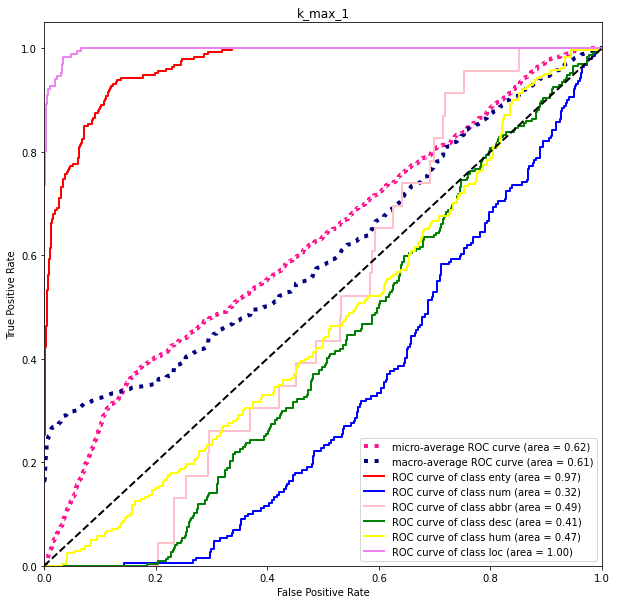

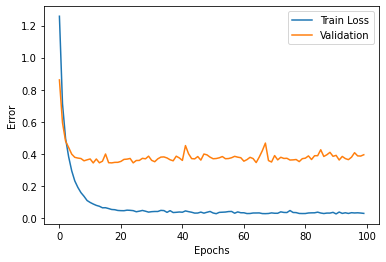

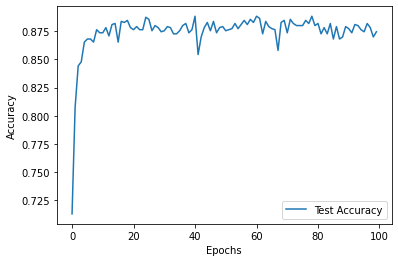

In [17]:
p = ['k_max',1]
param_dict = torch.load(path+'Embed/{}_{}_{}.pth'.format(300,p[0],p[1]))
model = Net(embedMatrix,conv_layers,100,6,pool_type = p[0],k_pool = p[1],inp_len = sen_max_len)

model.load_state_dict(param_dict['params'])
idx, batch  = next(enumerate(test_loader))
model.eval()
with torch.no_grad():
    logits = model(batch['data'])
    probs = torch.exp(logits)

print("=="*20 +'{}_{}'.format(p[0],p[1])+'=='*20)
generate_report(np.argmax(probs.numpy(),axis = 1),batch['label'].numpy())
generate_roc_curve(probs.numpy(),batch['label'].numpy(),'{}_{}'.format(p[0],p[1]),test_dataset.Y_unique,dir =path+'Embed/{}_{}_ROC.png'.format(p[0],p[1]))
save_plots([param_dict['train_losses'],param_dict['test_losses']],labels = ['Train Loss','Validation'],dir = path+'Embed/{}_{}_Er.png'.format(p[0],p[1]),ylabel = 'Error')
save_plots([np.array(param_dict['test_accuracies'])/100],labels = ['Test Accuracy'],dir = path+'Embed/{}_{}_Ac.png'.format(p[0],p[1]),ylabel = 'Accuracy')
    